<a href="https://colab.research.google.com/github/santinabardengo/TDVIII/blob/main/Proyecto_Final_Clasificaci%C3%B3n_Multiclase_(Test_Balanceado).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet_pytorch
!pip install -Uq wandb

  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import torch
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import copy
from torchsummary import summary
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms
import wandb
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
torch.manual_seed(162829)
if torch.cuda.is_available():
    torch.cuda.manual_seed(162829)

Wandb key: fd005b43ba216e7f8c0272801c9004c946bef281

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Conectamos el entorno a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_data_prov = pd.read_csv('/content/drive/MyDrive/Datos/train_multiclass_relabeled.csv')
test_data_prov = pd.read_csv('/content/drive/MyDrive/Datos/test_multiclass_relabeled.csv')

### Balanceo de clases en test para tener únicamente **cuatro** muestras de cada clase

#### Distribución de clases

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Datos/train_multiclass_testBalanced_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Datos/test_multiclass_testBalanced_data.csv")

<ipython-input-8-ac9921688fb6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data_prov, x='label', palette='viridis', ax=axes[0])
<ipython-input-8-ac9921688fb6>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='label', palette='viridis', ax=axes[1])


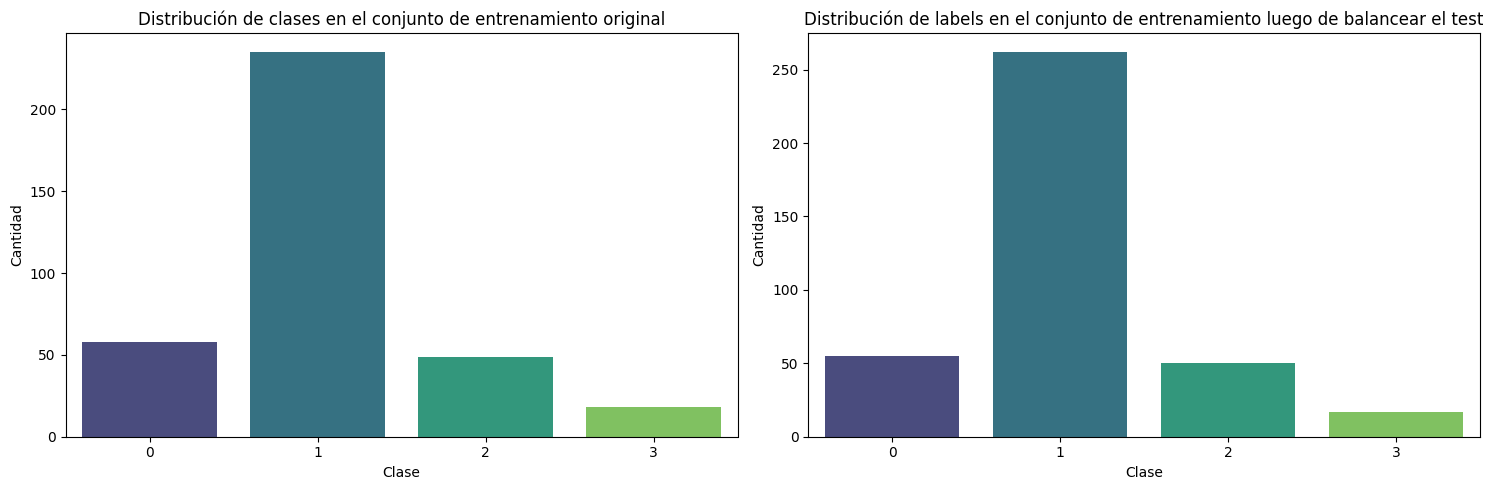

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=train_data_prov, x='label', palette='viridis', ax=axes[0])
axes[0].set_title('Distribución de clases en el conjunto de entrenamiento original')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

sns.countplot(data=train_data, x='label', palette='viridis', ax=axes[1])
axes[1].set_title('Distribución de labels en el conjunto de entrenamiento luego de balancear el test')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

<ipython-input-9-4f071c333219>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data_prov, x='label', palette='plasma', ax=axes[0])
<ipython-input-9-4f071c333219>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='label', palette='plasma', ax=axes[1])


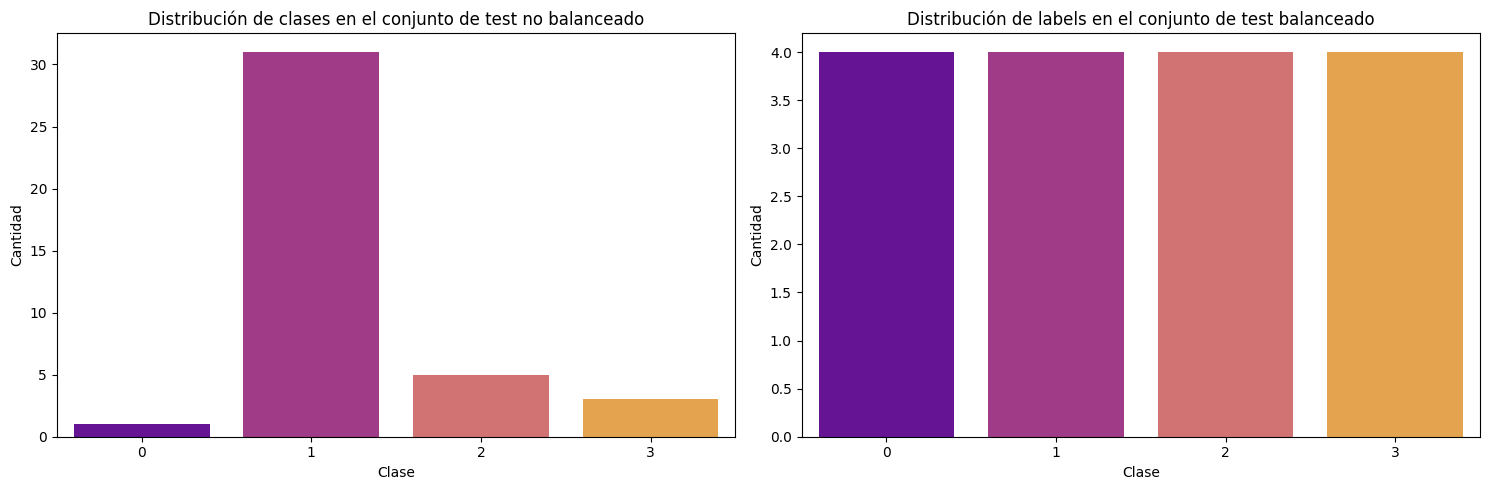

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=test_data_prov, x='label', palette='plasma', ax=axes[0])
axes[0].set_title('Distribución de clases en el conjunto de test no balanceado')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

sns.countplot(data=test_data, x='label', palette='plasma', ax=axes[1])
axes[1].set_title('Distribución de labels en el conjunto de test balanceado')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cargamos los modelos EfficientNet preentrenados junto con el tamaño de imagen que le corresponde a cada uno según su versión

In [ ]:
models = {
    "EfficientNet-b0": EfficientNet.from_pretrained('efficientnet-b0'),
    "EfficientNet-b1": EfficientNet.from_pretrained('efficientnet-b1'),
    "EfficientNet-b2": EfficientNet.from_pretrained('efficientnet-b2'),
    "EfficientNet-b3": EfficientNet.from_pretrained('efficientnet-b3'),
    "EfficientNet-b3": EfficientNet.from_pretrained('efficientnet-b4'),
}

image_sizes = {
    "EfficientNet-b0": 224,
    "EfficientNet-b1": 240,
    "EfficientNet-b2": 260,
    'EfficientNet-b3': 300,
    'EfficientNet-b4': 380,
}

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 161MB/s]


Loaded pretrained weights for efficientnet-b0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 97.3MB/s]


Loaded pretrained weights for efficientnet-b1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 113MB/s]


Loaded pretrained weights for efficientnet-b2


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 123MB/s]


Loaded pretrained weights for efficientnet-b3


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 119MB/s]


Loaded pretrained weights for efficientnet-b4


###Parámetros del mejor modelo

In [ ]:
batch_size = 64
learning_rate = 1e-4
epochs = 150
experiment_name = "EfficientNetb0"
project_name = "Multiclass-TestBalanced-PAPModel"
model_name = 'EfficientNet-b0'
interpolation_methods = [T.InterpolationMode.NEAREST, T.InterpolationMode.BILINEAR, T.InterpolationMode.BICUBIC]
interpolation = 'NearestInterpolation'

In [ ]:
images_dir = '/content/drive/MyDrive/Datos/' + model_name + '/' + interpolation + '/'

###Tranformaciones para realizar la aumentación de los datos

In [ ]:
def image_transformations():

    trans = [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]

    train_trans = [
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(contrast=0.2, brightness=0.2, saturation=0.2, hue=0.1)
    ]

    selected_transforms_train = random.sample(train_trans, 2)

    train_tfms = T.Compose(trans + selected_transforms_train)
    valid_tfms = T.Compose(trans)

    return train_tfms, valid_tfms

In [ ]:
def encode_label(label: list) -> list:
    return torch.tensor([label], dtype=torch.float32)

####Clase que se encarga de asociar el path de cada imagen a su archivo correspondiente y de realizar las transformaciones a las mismas durante el entrenamiento

In [ ]:
class PAPDataset(Dataset):

    def __init__(self, df, root_dir, transform):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.use_original_ratio = 0.4

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_fname, img_label = row['image_filename'], row['label']
        img = Image.open(self.root_dir + img_fname)

        # Random Augmentation
        if random.random() > self.use_original_ratio:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
            img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)

        return img, encode_label(img_label)

####Funciones para obtener train y test dataloader

In [ ]:
def get_train_dl(train_data, batch_size = 16):

    np.random.seed(162829)
    train_ds, val_ds = train_test_split(train_data, test_size = 0.3, random_state=162829, shuffle=True, stratify= train_data['label'])

    train_ds.reset_index(drop=True, inplace=True)
    val_ds.reset_index(drop=True, inplace=True)

    train_tfms, valid_tfms = image_transformations()

    train_ds = PAPDataset(train_ds, images_dir, transform = train_tfms)
    val_ds = PAPDataset(val_ds, images_dir, transform = valid_tfms)

    train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True, num_workers=2)

    return train_dl, val_dl

In [ ]:
def get_test_dl(test_data, batch_size = 16):

    _, test_tfms = image_transformations()

    test_data = PAPDataset(test_data, images_dir, transform = test_tfms)

    test_dl = torch.utils.data.DataLoader(test_data, batch_size, num_workers=2)

    return test_dl

####Función para calcular las métricas del modelo (accuracy, precision, recall y F1-score)

In [ ]:
def compute_metrics(TP: torch.Tensor, TN: torch.Tensor, FP: torch.Tensor, FN: torch.Tensor) -> dict:

    precision_list = []
    recall_list = []
    F1_list = []
    accuracy_list = []

    for i in range(len(TP)):
        precision = TP[i] / (TP[i] + FP[i] + 1e-12)
        recall = TP[i] / (TP[i] + FN[i] + 1e-12)
        F1 = (2 * precision * recall) / (precision + recall + 1e-12)
        accuracy = (TP[i] + TN[i]) / (TP[i] + TN[i] + FP[i] + FN[i] + 1e-12)

        precision_list.append(precision)
        recall_list.append(recall)
        F1_list.append(F1)
        accuracy_list.append(accuracy)

    precision = torch.mean(torch.tensor(precision_list)).item()
    recall = torch.mean(torch.tensor(recall_list)).item()
    F1 = torch.mean(torch.tensor(F1_list)).item()
    accuracy = torch.mean(torch.tensor(accuracy_list)).item()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': F1,
    }

####Función para obtener la matriz de confusión

In [ ]:
def confusionMatrix(predicted: list, label: list):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(label, predicted), cmap='Blues', annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

###Definimos el modelo a utilizar (modelo EfficientNet preentrenado + FF)

In [ ]:
class PAPModel(nn.Module):
    def get_sequential(num_ftrs):
        linear_layers = nn.Sequential(
                nn.BatchNorm1d(num_features=num_ftrs),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.BatchNorm1d(1024),
                nn.Dropout(0.4),
                nn.Linear(1024, 256),
                nn.ReLU(),
                nn.BatchNorm1d(num_features=256),
                nn.Dropout(0.4),
                nn.Linear(256, 4),
            )
        return linear_layers

    def __init__(self, model_name=None, model=None, input_size=None):
        super().__init__()

        self.model_name = model_name
        self.model = copy.deepcopy(model)
        self.IS = input_size

        self.num_ftrs = self.model._fc.in_features
        self.model._fc = PAPModel.get_sequential(self.num_ftrs)

    def forward(self, xb):
        return self.model(xb)

    # Función para congelar los parámetros del modelo preentrenado
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model._fc.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

model = PAPModel(model_name, models[model_name], image_sizes[model_name])
model.to(device)

PAPModel(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
   

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
# optimizer = optim.Adam(model.model._fc.parameters(), learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, cooldown=1)

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project = project_name,
    name = experiment_name,
    entity = '',
    # track hyperparameters and run metadata
    config={
        "baseModel": model_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs,
        "image_size": image_sizes[model_name],
        "optimizer": optimizer,
        "interpolation": interpolation,
    }
)

wandb: Currently logged in as: caromilisanti44 (caromilisanti44-universidad-torcuato-di-tella). Use `wandb login --relogin` to force relogin


In [ ]:
train_dl, valid_dl = get_train_dl(train_data, batch_size)

###Entrenamos el modelo y nos guardamos el mejor según la función de pérdida

In [ ]:
best_val_score = 0
lowest_val_loss = float('inf')
best_epoch = 0
patience = 20
patience_counter = 0

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    TP_total = torch.zeros(4).to(device)
    TN_total = torch.zeros(4).to(device)
    FP_total = torch.zeros(4).to(device)
    FN_total = torch.zeros(4).to(device)
    total = 0

    # Entrenamiento
    model.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)

        _, predicted = torch.max(outputs, 1)

        for i in range(4):  # Para cada clase
            TP_total[i] += ((predicted == i) & (labels == i)).sum().item()
            TN_total[i] += ((predicted != i) & (labels != i)).sum().item()
            FP_total[i] += ((predicted == i) & (labels != i)).sum().item()
            FN_total[i] += ((predicted != i) & (labels == i)).sum().item()

    train_score = compute_metrics(TP_total, TN_total, FP_total, FN_total)
    running_loss = running_loss/total

    val_correct = 0
    total = 0
    val_loss = 0
    TP_total = torch.zeros(4).to(device)
    TN_total = torch.zeros(4).to(device)
    FP_total = torch.zeros(4).to(device)
    FN_total = torch.zeros(4).to(device)

    # Validación
    with torch.no_grad():
        for data in valid_dl:
            images, labels = data[0].to(device), data[1].to(device)
            labels = labels.squeeze().long()
            outputs = model(images)
            total += labels.size(0)

            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)

            for i in range(4):
                TP_total[i] += ((predicted == i) & (labels == i)).sum().item()
                TN_total[i] += ((predicted != i) & (labels != i)).sum().item()
                FP_total[i] += ((predicted == i) & (labels != i)).sum().item()
                FN_total[i] += ((predicted != i) & (labels == i)).sum().item()

    val_score = compute_metrics(TP_total, TN_total, FP_total, FN_total)
    val_loss = val_loss / total
    # scheduler.step(val_loss)

    print(f'{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]["lr"]:.6f}, train loss: {running_loss:.3f}, val loss: {val_loss:.3f}, train_score: {train_score}, val_score: {val_score}')

    wandb.log({ "train_score": train_score, "val_score": val_score, "train_loss": running_loss,
             "val_loss": val_loss})

    # Si la pérdida en validación fue mas baja, guardamos ese modelo
    if val_loss < lowest_val_loss:
        best_epoch = epoch
        lowest_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'{experiment_name}.pth')
        print(f"Guardando el modelo para la época {epoch + 1}, val_loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No hubo mejora en la validación. Paciencia: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping activado. Fin del entrenamiento.")
        break

print(f'Best Loss: {str(lowest_val_loss)}.')
print(f'Best Epoch: {str(best_epoch)}.')
print('Finished Training')

1 / 150, lr: 0.000100, train loss: 0.027, val loss: 0.023, train_score: {'accuracy': 0.6511194109916687, 'precision': 0.28575414419174194, 'recall': 0.33690938353538513, 'F1': 0.24967746436595917}, val_score: {'accuracy': 0.6982758641242981, 'precision': 0.394975483417511, 'recall': 0.4748820960521698, 'F1': 0.3480711281299591}
Guardando el modelo para la época 1, val_loss: 0.0231
2 / 150, lr: 0.000100, train loss: 0.026, val loss: 0.021, train_score: {'accuracy': 0.6940298080444336, 'precision': 0.3918115198612213, 'recall': 0.4769793450832367, 'F1': 0.34734711050987244}, val_score: {'accuracy': 0.7413793206214905, 'precision': 0.45026424527168274, 'recall': 0.5873169898986816, 'F1': 0.42659619450569153}
Guardando el modelo para la época 2, val_loss: 0.0211
3 / 150, lr: 0.000100, train loss: 0.023, val loss: 0.019, train_score: {'accuracy': 0.7388060092926025, 'precision': 0.4277855157852173, 'recall': 0.541350781917572, 'F1': 0.40738946199417114}, val_score: {'accuracy': 0.75, 'preci

In [ ]:
wandb.finish()

train_loss,██▇▆▅▄▄▃▂▃▂▂▂▂▂▁▂▁▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▇▆▅▅▅▄▃▄▃▃▃▃▃▃▃▃▃▂▃▂▂▃▃▂▃▃▁▂▃▂▁▃▂▂▂▃▂▃▂
train_loss,0.00189
val_loss,0.00896


#### Cargamos el mejor modelo

In [ ]:
PATH = './' + experiment_name + '.pth'
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
test_dl = get_test_dl(test_data, batch_size=len(test_data))

###Utilizamos el mejor modelo para evaluar en el dataset de test

In [ ]:
model.eval()

all_preds = []
all_labels = []

TP_total = torch.zeros(4).to(device)
TN_total = torch.zeros(4).to(device)
FP_total = torch.zeros(4).to(device)
FN_total = torch.zeros(4).to(device)

with torch.no_grad():
  for data in test_dl:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      labels = labels.squeeze().long()

      all_preds.extend(predicted.cpu().numpy().flatten())
      all_labels.extend(labels.cpu().numpy().flatten())

      for i in range(4):
        TP_total[i] = ((predicted.cpu() == i) & (labels.cpu() == i)).sum()
        TN_total[i] = ((predicted.cpu() != i) & (labels.cpu() != i)).sum()
        FP_total[i] = ((predicted.cpu() == i) & (labels.cpu() != i)).sum()
        FN_total[i] = ((predicted.cpu() != i) & (labels.cpu() == i)).sum()

  for i in range(len(labels)):
    label = labels[i].cpu().item()  # Obtenemos el valor de la etiqueta
    prediction = predicted[i].cpu().item()  # Obtenemos el valor de la predicción
    print(f"Label = {label}, Predicción = {prediction}")

Label = 2, Predicción = 3
Label = 1, Predicción = 0
Label = 3, Predicción = 3
Label = 3, Predicción = 3
Label = 0, Predicción = 0
Label = 1, Predicción = 1
Label = 2, Predicción = 2
Label = 1, Predicción = 1
Label = 2, Predicción = 2
Label = 3, Predicción = 3
Label = 1, Predicción = 1
Label = 2, Predicción = 1
Label = 0, Predicción = 0
Label = 0, Predicción = 1
Label = 0, Predicción = 0
Label = 3, Predicción = 3


####Hacemos la matriz de confusión para los resultados de test e imprimimos las métricas

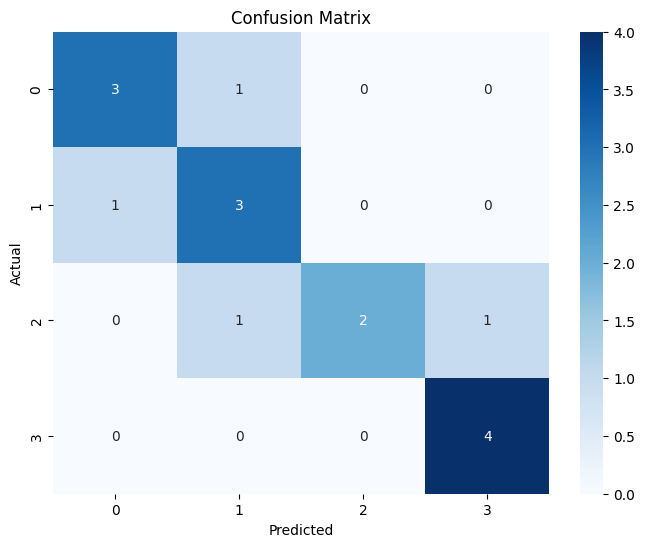

{'accuracy': 0.875, 'precision': 0.7874999642372131, 'recall': 0.75, 'F1': 0.7430555820465088}


In [ ]:
confusionMatrix(all_preds, all_labels)
print(compute_metrics(TP_total, TN_total, FP_total, FN_total))